In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from fxpmath import Fxp
import copy
import math
import itertools as iter

In [4]:
#method for quantizing a numpy array
def quantisation(inputArray, bitSize, fractBits = 0):
     #compute scale and zeroPoint
    maximum = np.max(inputArray);
    minimum = np.min(inputArray);
    valueRange = maximum - minimum;
    
    #using a fxpMath dummy to get the bounds for quantisation
    fxDummy = Fxp(1,signed = (minimum < 0), n_word = bitSize, n_frac = fractBits)
    maxFpVal = fxDummy.upper
    minFpVal = fxDummy.lower

    #scale = 1 when only one value is present to avoid division by 0
    scale = 1;
    if (valueRange != 0):
        scale = (maxFpVal - minFpVal) / valueRange;
    zeroPoint = minFpVal-(scale*minimum);
    
    #the actual quantisation and restructuring into a fxp-array
    output = Fxp((inputArray * scale) + zeroPoint, (minimum < 0), bitSize, fractBits)

    return output;

def fixedPointConversion(inputArray, bitSize, fractBits = 0):
    output = Fxp(inputArray, signed= True, n_word = bitSize, n_frac = fractBits)
    return (output)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 6, 6, 64)        

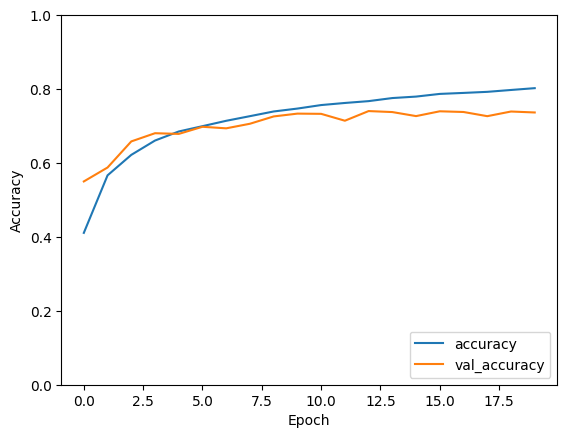

313/313 - 1s - loss: 0.7827 - accuracy: 0.7366 - 652ms/epoch - 2ms/step
0.7365999817848206


In [6]:
(trainingImages, trainingLabels), (testImages, testLabels) = cifar10.load_data()

#normalizing the values to 0-1
trainingImages = trainingImages / 255.0
testImages = testImages / 255.0

# One hot encoding the target class (labels)
num_classes = 10
trainingLabels = tf.keras.utils.to_categorical(trainingLabels, num_classes)
testLabels = tf.keras.utils.to_categorical(testLabels, num_classes)

#convolution layers for feature extraction
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.1))


#fully connected layers for class prediction
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

#print the current model summary
model.summary()

#preparing model for training
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

#training the model
history = model.fit(trainingImages, trainingLabels, epochs=20, 
                    validation_data=(testImages, testLabels))

#set to True to display the changing accuracy of the model during training
if(True):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

#display the accuracy of the trained model
test_loss, test_acc = model.evaluate(testImages,  testLabels, verbose=2)
print(test_acc)

#get the weights of the model 
weights = model.get_weights()

In [9]:
#save model
model.save("trained_classifier")

INFO:tensorflow:Assets written to: trained_classifier\assets


INFO:tensorflow:Assets written to: trained_classifier\assets


In [10]:
#load model
model = tf.keras.models.load_model("trained_classifier")

In [7]:
###second Version

#determine needed non-fractional Bits
modelCpy = copy.deepcopy(model)
layerCount = len(model.layers)
fractBitsSearchSpace = [2,4,8]
tolerance = 0.1
decimalBits = []
nonEmptyLayerIdx = []
accuracies = []
for idx in range(layerCount):
    if (modelCpy.layers[idx].get_weights() != []):
        nonEmptyLayerIdx.append(idx)

print(nonEmptyLayerIdx)


for layerIdx in range(layerCount):
    if not(layerIdx in nonEmptyLayerIdx):
        decimalBits.append(0)
    else:
        minimum = math.floor(min(np.min(modelCpy.layers[layerIdx].get_weights()[0]), np.min(modelCpy.layers[layerIdx].get_weights()[1])))  
        maximum = math.ceil(max(np.max(modelCpy.layers[layerIdx].get_weights()[0]), np.max(modelCpy.layers[layerIdx].get_weights()[1])))
        valueRange = max(maximum, 0) - min(minimum, 0)
        if (valueRange > 0):
            decimalBits.append(math.ceil(math.log(valueRange, 2)))
        else:
            print("Error: Value Range is 0 or negative")

print (decimalBits)

permutations = list(iter.product(fractBitsSearchSpace, repeat = len(nonEmptyLayerIdx)))
print(len(permutations))
print(permutations)
for permutation in range(len(permutations)):
    for layerIdx in nonEmptyLayerIdx:
        currentFractBits = permutations[permutation][nonEmptyLayerIdx.index(layerIdx)]
        newLayer = []
        newLayer.append(fixedPointConversion(copy.deepcopy(model.layers[layerIdx].get_weights()[0]), decimalBits[layerIdx] + currentFractBits, currentFractBits))
        newLayer.append(fixedPointConversion(copy.deepcopy(model.layers[layerIdx].get_weights()[1]), decimalBits[layerIdx] + currentFractBits, currentFractBits))
        modelCpy.layers[layerIdx].set_weights(newLayer)
    test_loss, test_acc = modelCpy.evaluate(testImages,  testLabels, verbose=0)
    accuracies.append(test_acc)
    print("run: " + str(permutation))
    print(test_acc)

print(len(accuracies), len(permutations))

ratios = []
minimumAccuracy = max(accuracies) - tolerance
for idx in range(len(permutations)):
    if (accuracies[idx] < minimumAccuracy):
        ratios.append(0)
    else:
        ratios.append(sum(permutations[idx]) / accuracies[idx])

bestPermutation = permutations[ratios.index(max(ratios))]
for layerIdx in nonEmptyLayerIdx:
        currentFractBits = bestPermutation[nonEmptyLayerIdx.index(layerIdx)]
        newLayer = []
        newLayer.append(fixedPointConversion(copy.deepcopy(model.layers[layerIdx].get_weights()[0]), decimalBits[layerIdx] + currentFractBits, currentFractBits))
        newLayer.append(fixedPointConversion(copy.deepcopy(model.layers[layerIdx].get_weights()[1]), decimalBits[layerIdx] + currentFractBits, currentFractBits))
        modelCpy.layers[layerIdx].set_weights(newLayer)

test_loss, test_acc = modelCpy.evaluate(testImages,  testLabels, verbose=0)
print("new accuracy")
print(test_acc)
print("mean used Bits")
print(sum(bestPermutation)/len(bestPermutation))


[0, 3, 6, 9, 10, 11]
[1, 0, 0, 2, 0, 0, 2, 0, 0, 1, 1, 1]
729
[(2, 2, 2, 2, 2, 2), (2, 2, 2, 2, 2, 4), (2, 2, 2, 2, 2, 8), (2, 2, 2, 2, 4, 2), (2, 2, 2, 2, 4, 4), (2, 2, 2, 2, 4, 8), (2, 2, 2, 2, 8, 2), (2, 2, 2, 2, 8, 4), (2, 2, 2, 2, 8, 8), (2, 2, 2, 4, 2, 2), (2, 2, 2, 4, 2, 4), (2, 2, 2, 4, 2, 8), (2, 2, 2, 4, 4, 2), (2, 2, 2, 4, 4, 4), (2, 2, 2, 4, 4, 8), (2, 2, 2, 4, 8, 2), (2, 2, 2, 4, 8, 4), (2, 2, 2, 4, 8, 8), (2, 2, 2, 8, 2, 2), (2, 2, 2, 8, 2, 4), (2, 2, 2, 8, 2, 8), (2, 2, 2, 8, 4, 2), (2, 2, 2, 8, 4, 4), (2, 2, 2, 8, 4, 8), (2, 2, 2, 8, 8, 2), (2, 2, 2, 8, 8, 4), (2, 2, 2, 8, 8, 8), (2, 2, 4, 2, 2, 2), (2, 2, 4, 2, 2, 4), (2, 2, 4, 2, 2, 8), (2, 2, 4, 2, 4, 2), (2, 2, 4, 2, 4, 4), (2, 2, 4, 2, 4, 8), (2, 2, 4, 2, 8, 2), (2, 2, 4, 2, 8, 4), (2, 2, 4, 2, 8, 8), (2, 2, 4, 4, 2, 2), (2, 2, 4, 4, 2, 4), (2, 2, 4, 4, 2, 8), (2, 2, 4, 4, 4, 2), (2, 2, 4, 4, 4, 4), (2, 2, 4, 4, 4, 8), (2, 2, 4, 4, 8, 2), (2, 2, 4, 4, 8, 4), (2, 2, 4, 4, 8, 8), (2, 2, 4, 8, 2, 2), (2, 2, 4, 8, 2, 4

In [13]:
###first Version
fractBitsList = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
maxBitSize = 24
tolerancePerLayer = 0.05
layerCount = len(model.layers)
averageStorageUse = []
accuracyDeveloptment = [test_acc]

#optimizes layer by layer
for currentLayer in range(layerCount):
    originalLayer = copy.deepcopy(model.layers[currentLayer])
    #only computes if layer has weights
    if (originalLayer.get_weights() != []):
        #initializes matrix for storing layer accuracy
        layerAccuracy =  np.zeros((maxBitSize, len(fractBitsList)))
        #iterates over specified numberfs of fractional bits, and specified number of overall bits for each
        for fractBitsIdx in range(len(fractBitsList)):
            for bits in range(max(fractBitsList[fractBitsIdx], 1), maxBitSize + 1):
                #initializes a new container for all weights of the current layer
                newLayer = []
                #iterates over all sets of weights in layer (needed, because the list of all weights has inhomogenus shape, so numpy cant handle it)
                for weightCount in range(len(originalLayer.get_weights())):
                    #append the quantized weights to new layer
                    newLayer.append(fixedPointConversion(copy.deepcopy(originalLayer.get_weights()[weightCount]), bits, fractBitsList[fractBitsIdx]))
                #sets the new layer
                model.layers[currentLayer].set_weights(newLayer)
                #tests the new accuracy and stores it in a matrix
                test_loss, test_acc = model.evaluate(testImages,  testLabels, verbose=0)
                layerAccuracy[bits-1][fractBitsIdx] = test_acc        

        #detecting the best accuracy by tolerance
        #ToDo: optimize the function picking the best sizes
        bestAccuracy = {"bitIdx" : 0, "fractIdx" : 0, "accuracy" : 0}
        for bits in range(maxBitSize):
            for fractBits in range(len(fractBitsList)):
                if ((layerAccuracy[bits][fractBits] - tolerancePerLayer) > bestAccuracy["accuracy"]):
                    bestAccuracy["bitIdx"] = bits
                    bestAccuracy["fractIdx"] = fractBits
                    bestAccuracy["accuracy"] = layerAccuracy[bits][fractBits]
        
        #set the final new weights
        if (bestAccuracy["bitIdx"] > 0):
            newLayer = []
            for weightCount in range(len(originalLayer.get_weights())):
                newLayer.append(fixedPointConversion(copy.deepcopy(originalLayer.get_weights()[weightCount]), bestAccuracy["bitIdx"] + 1, fractBitsList[bestAccuracy["fractIdx"]]))
            model.layers[currentLayer].set_weights(newLayer)
        print("Layer: " + str(currentLayer) + " bits: " + str(bestAccuracy["bitIdx"] + 1) + " fractional Bits: " + str(fractBitsList[bestAccuracy["fractIdx"]]) + " Accuracy: ")
        averageStorageUse.append(bestAccuracy["bitIdx"] + 1)
        test_loss, test_acc = model.evaluate(testImages,  testLabels, verbose=0)
        print (test_acc)
        accuracyDeveloptment.append(test_acc)

plt.xlabel("Quantized Layer")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.plot(accuracyDeveloptment)
plt.show()

print("average storage use: " + str(np.mean(averageStorageUse)) + " Bits")

TypeError: cannot pickle 'FuncGraph' object